# Hyperspectral CNN

This code is to train the Hyperspectral CNN. Warning: You need at least 18GB of RAM, to process the TfRecords.

In [ ]:
from __future__ import annotations
from collections.abc import Mapping

import tensorflow as tf
import numpy as np

class TfrecordHelper():
    def __init__(self, path: str, ls_bands = "ms", nl_band = None):
        """
        Init function for creating the TfrecordHelper object.

        Args:
        - path (str): Path where tfrecord file is located.
        - ls_bands (str): Select landsat bands, "ms" (default) for all bands or "rgb" for RED, BLUE, GREEN bands.
        - nl_bands (str): For including the nightlight band, set any other value then None (default).

        """

        self.raw_dataset: tf.TFRecordDataset = tf.data.TFRecordDataset(path, compression_type="GZIP")
        self.dataset: tf.TFRecordDataset | None = None
        self.ls_bands: str = ls_bands
        self.nl_band: str | None = nl_band
        self.nbands = 8
        # use the keywords used in the csv file to scrape the tfrecords from gee
        self.keyword_year = "year"
        self.keyword_lat = "lat"
        self.keyword_lon = "lon"
        self.scalar_keys = [self.keyword_lat, self.keyword_lon, self.keyword_year] # used 
        self.means = None
        self.stads = None
    
    def process_dataset(self, normalize = False):
        """
        Method for processing the raw_dataset based on selected bands.
        """
        
        x = np.empty(shape=(255**2))
        x.fill(0)
        def_value = tf.convert_to_tensor(x, tf.float32)

        def process_tfrecord(record: tf.train.Example) -> dict[any, any, any]:
            """
            Helper function for the map call, which processes the each tfrecord (feature).

            Args: 
            - record (tf.train.Example): feature to process
            
            Returns: 
            result (dict[any, any, any]): contains processed feature
            """
            bands = []
            if self.ls_bands == "rgb":
                # bands = ["BLUE", "GREEN", "RED"]  # BGR order
                bands = ["RED", "GREEN", "BLUE"]
            elif self.ls_bands == "ms":
                bands = ["RED", "GREEN", "BLUE", "SWIR1", "SWIR2", "TEMP1", "NIR"]
            if self.nl_band is not None:
                bands += ["NIGHTLIGHTS"]

            keys_to_features = {}
            for band in bands:
                keys_to_features[band] = tf.io.FixedLenFeature(shape=[255**2], dtype=tf.float32, default_value=def_value)
            for key in self.scalar_keys:
                keys_to_features[key] = tf.io.FixedLenFeature(shape=[], dtype=tf.float32)
        
            
           
            # cons_pc = tf.cast(ex.get("cons_pc", -1), tf.float32)

            ex = tf.io.parse_single_example(record, features=keys_to_features)
            loc = tf.stack([ex[self.keyword_lat], ex[self.keyword_lon]])
            year = tf.cast(ex.get("year", -1), tf.int32)
            for band in bands:
                ex[band].set_shape([255 * 255])
                # reshape to (255, 255) and crop to (224, 224)
                ex[band] = tf.reshape(ex[band], [255, 255])[15:-16, 15:-16]
                if normalize:
                    if band == "NIGHTLIGHTS":
                        ex[band] = (ex[band] - self.means["VIIRS"]) / self.stads["VIIRS"]
                    else:
                        ex[band] = (ex[band] - self.means[band]) / self.stads[band]

            img = tf.stack([ex[band] for band in bands], axis=2)
            result = {"images": img, "locs": loc, "years": year}
            return result
        
        self.dataset = self.raw_dataset.map(process_tfrecord, num_parallel_calls=3)
    

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from bisect import bisect
from sklearn.mixture import GaussianMixture as GMM
from torch.optim import lr_scheduler
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from tqdm.notebook import tqdm

import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim

## Load data and preprocess

In [ ]:
def load_dataset(path: str):
    """
    Helper to load dataset

    Args:
    - path (str): Path to dataset

    Returns:
    - dic which contains all data
    """
    tf_helper = TfrecordHelper(path, ls_bands="ms", nl_band="viirs")
    input_dic = {}
    tf_helper.keyword_lat = "lat"
    tf_helper.keyword_lon = "lon"
    tf_helper.process_dataset()
    for i, feature in enumerate(tf_helper.dataset):
        input_dic[i] = {
        "year": feature["years"].numpy(),
        "cluster_lat": feature["locs"].numpy()[0],
        "cluster_lon": feature["locs"].numpy()[1],
        "img": (feature["images"][:,:,:7].numpy()),
        "nightlight": np.mean(feature["images"][:,:,7].numpy()),
    }
    
    # Remove data where entry is broken (one channel contains only zeros)
    remove = []
    for feature in tqdm(input_dic):
        if input_dic[feature]["nightlight"] == 0:
            remove.append(feature)
            continue
        for dim in input_dic[feature]["img"]:
            if not np.any(dim):
                remove.append(feature)
                break
    
    for r in remove:
        input_dic.pop(r)
    return input_dic

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/src

/content/drive/MyDrive/src


In [ ]:
continent: str = 'africa'
path: str = f"../data/continents/{continent}/tfrecords/raw/" # path to the processed tfrecords from the previous step
files: list = os.listdir(path) 

In [ ]:
input_dics = [] # will contain all information
for file in files:
    raw_path = path + file
    data = load_dataset(raw_path)
    input_dics.append(data)

In [ ]:
X = []
y = []
years = []
lat = []
lon = []
for country in tqdm(input_dics):
    data = country
    for feature in data:
        years.append(data[feature]["year"])
        lat.append(data[feature]["cluster_lat"])
        lon.append(data[feature]["cluster_lon"])
        data[feature]["img"][:3,:,:] *=3 # RGB images to dark, got better performance by using it
        X.append(data[feature]["img"])
        y.append(data[feature]["nightlight"])
X = np.array(X)
y = np.array(y)

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
means = [np.mean(X[:,:,i,:]) for i in range(7)]
stds = [np.std(X[:,:,i,:]) for i in range(7)]

In [ ]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

## Bins for nighttime images

In [ ]:
def nightlights_to_class(data):
    """
    Data are labels. Perform GMM based on the input and creates 5 classes out of it.

    Args:
    - data: radiance (nighttime images)

    Return:
    - list of labels
    """
    x = data.reshape(-1,1)
    gmm = GMM(n_components=5).fit(x)
    labels = gmm.predict(x)
    cut_label1 = data[labels==0].max()
    cut_label2 = data[labels==1].max()
    cut_label3 = data[labels==2].max()
    cut_label4 = data[labels==3].max()
    cut_label5 = data[labels==4].max()
    cutoffs = [cut_label1, cut_label2, cut_label3,  cut_label4, cut_label5]
    cutoffs = sorted(cutoffs)
    
    y_labels = []
    for d in data:
        if d <= cutoffs[0]:
            y_labels.append(0)
        elif d <= cutoffs[1]:
            y_labels.append(1)
        elif d <= cutoffs[2]:
            y_labels.append(2)
        elif d <= cutoffs[3]:
            y_labels.append(3)
        else:
            y_labels.append(4)
    return np.array(y_labels)

In [ ]:
y_labels = nightlights_to_class(y)

## Pytorch Dataset

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        if self.transform:
           x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.data)

In [ ]:
dataset = MyDataset(X, y_labels, preprocess)

In [ ]:
loader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

In [ ]:
indices = list(range(len(dataset)))
split = int(np.floor(.4 * len(dataset)))
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                                sampler=valid_sampler)
dataloaders = {
    "train": train_loader,
    "val": validation_loader
}

dataset_sizes = {
    "train": len(train_sampler),
    "val": len(valid_sampler)
}

## CNN

In [ ]:
train_acc: list = []
val_acc: list = []

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_acc.append([])
    val_acc.append([])

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'val':
                val_acc[-1].append(epoch_acc)
            else:
                train_acc[-1].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Load 3 pre-trained CNNs:
- ResNet18
- ResNet50
- ResNet152


In [ ]:
models: list = [torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True),
                torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True),
                torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True) ]

Hyperspectral Setting

In [ ]:
new_input = nn.Conv2d(7, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), dilation=1, bias=False)
for model in models:
    model.conv1 = new_input

Modify outputs

In [ ]:
model_fts = []
for model in models:
  model_ft = model
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Linear(num_ftrs, 5)
  model_ft = model_ft.to(device)
  model_fts.append(model_ft)

In [ ]:
# Train all the models
for model_ft in model_fts:
  criterion = nn.CrossEntropyLoss()
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
  model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 1.0826 Acc: 0.5686
val Loss: 1.6384 Acc: 0.2471

Epoch 1/49
----------
train Loss: 0.9456 Acc: 0.6106
val Loss: 1.1289 Acc: 0.2479

Epoch 2/49
----------
train Loss: 0.9073 Acc: 0.6257
val Loss: 1.4901 Acc: 0.2388

Epoch 3/49
----------
train Loss: 0.8618 Acc: 0.6398
val Loss: 2.1433 Acc: 0.2463

Epoch 4/49
----------
train Loss: 0.8099 Acc: 0.6556
val Loss: 1.3331 Acc: 0.2471

Epoch 5/49
----------
train Loss: 0.7765 Acc: 0.6848
val Loss: 4.8708 Acc: 0.0280

Epoch 6/49
----------
train Loss: 0.7272 Acc: 0.7028
val Loss: 0.8428 Acc: 0.6840

Epoch 7/49
----------
train Loss: 0.6449 Acc: 0.7400
val Loss: 1.7415 Acc: 0.2471

Epoch 8/49
----------
train Loss: 0.6239 Acc: 0.7521
val Loss: 0.7769 Acc: 0.7123

Epoch 9/49
----------
train Loss: 0.5911 Acc: 0.7660
val Loss: 0.7536 Acc: 0.7113

Epoch 10/49
----------
train Loss: 0.5947 Acc: 0.7683
val Loss: 1.0071 Acc: 0.3021

Epoch 11/49
----------
train Loss: 0.5888 Acc: 0.7694
val Loss: 2.6004 Acc: 0.2206

Ep

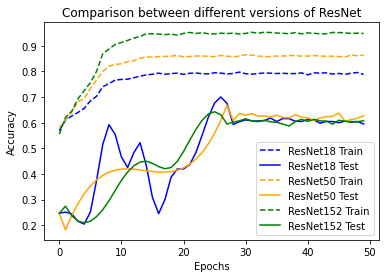

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev

# Reduce the variation of test accuracy in first epochs using spline interpolation of first order
red_val_acc: list = []
low: int = 1 # First epoch where to start applying spline
high: int = 28 # Last epoch where to start applying spline

for i in range(3):
    bspl_y = []
    for epoch in range(0, low):
        bspl_y.append(val_acc[i][epoch].item())
    y = []
    for epoch in range(low, high):
        y.append(val_acc[i][epoch].item())
    bspl = splrep(range(low, high), y, s=1)
    bspl_y.extend(splev(range(low, high), bspl))
    for epoch in range(high, 50):
        bspl_y.append(val_acc[i][epoch].item())

    red_val_acc.append(bspl_y)

# Plot the train and test loss for each model
plt.clf()
plt.plot(list(map(lambda x : x.item(), train_acc[0])), '--', color='blue', label="ResNet18 Train")
plt.plot(red_val_acc[0], color='blue', label="ResNet18 Test")

plt.plot(list(map(lambda x : x.item(), train_acc[1])), '--', color='orange', label="ResNet50 Train")
plt.plot(red_val_acc[1], color='orange', label="ResNet50 Test")

plt.plot(list(map(lambda x : x.item(), train_acc[2])), '--', color='green', label="ResNet152 Train")
plt.plot(red_val_acc[2], color='green', label="ResNet152 Test")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the chart
plt.legend(loc='lower right')
plt.xticks(range(0, 60, 10))
plt.title('Comparison between different versions of ResNet')

# Show the plot
plt.savefig(f'../data/continents/{continent}/tot_acc.pdf', dpi=600, bbox_inches='tight')

In [ ]:
# Extract information about mean and variance of models
data = [
    {'model': 'ResNet18', 'mean': np.mean(list(map(lambda x : x.item(), val_acc[0]))), 'variance': np.std(list(map(lambda x : x.item(), val_acc[0])))},
    {'model': 'ResNet50', 'mean': np.mean(list(map(lambda x : x.item(), val_acc[1]))), 'variance': np.std(list(map(lambda x : x.item(), val_acc[1])))},
    {'model': 'ResNet152', 'mean': np.mean(list(map(lambda x : x.item(), val_acc[2]))), 'variance': np.std(list(map(lambda x : x.item(), val_acc[2])))},
]

0.20413690818383345
0.18064313080288893
0.20109243899050155


In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
colors = ['blue', 'orange', 'green']

# Plot the min bullets
fig.add_trace(go.Scatter(x=[d['model'] for d in data],
                         y=[min(list(map(lambda x : x.item(), v))) for v in val_acc],
                         mode="markers",
                         showlegend=False,
                         marker=dict(color=colors,
                                     size=10)))
# Plot the mean bullets
fig.add_trace(go.Scatter(x=[d['model'] for d in data],
                         y=[np.mean(list(map(lambda x : x.item(), v))) for v in val_acc],
                         mode="markers",
                         showlegend=False,
                         marker=dict(color=colors,
                                     size=20)))

# Plot the max bullets
fig.add_trace(go.Scatter(x=[d['model'] for d in data],
                         y=[max(list(map(lambda x : x.item(), v))) for v in val_acc],
                         mode="markers",
                         showlegend=False,
                         marker=dict(color=colors,
                                     size=10)))

# Plot the line between max and min bullets
for i, row in enumerate(data):
    fig.add_shape(
        dict(type="line",
              x0=row["model"],
              x1=row["model"],
              y0=min(list(map(lambda x : x.item(), val_acc[i]))),
              y1=max(list(map(lambda x : x.item(), val_acc[i]))),
              line=dict(
                color=colors[i],
                width=2)))

fig.update_layout(title="Test accuracy", xaxis_title='Models', yaxis_title='Accuracy', title_x=0.5)
fig.show()

In [ ]:
# Save trained models' weights
for id, model in enumerate(models):
    torch.save(model.state_dict(), f'../data/continents/{continent}/model_{id}/cnn_weights/model_weights_all_countries_multichannel_{time.time()}.pth')

## Extract Weights

In [ ]:
nmodels = []
for model_ft in model_fts:
  nmodel = torch.nn.Sequential(*list(model_ft.children())[:-1])
  if torch.cuda.is_available():
    nmodel = nmodel.to('cuda')
  nmodels.append(nmodel)

Forward pass

In [ ]:
for id, nmodel in enumerate(nmodels):
  input_dic = copy.deepcopy(input_dics)
  for data in input_dic:
      for feature in tqdm(data, total=len(data)):
          input_batch = preprocess(data[feature]['img']).unsqueeze(0)
          with torch.no_grad():
              output = nmodel(input_batch.to('cuda'))
          data[feature]["feature"] = np.squeeze(output.cpu())

  df = pd.DataFrame()
  for data in input_dic:
      years = []
      lat = []
      lon = []
      features = []
      nightlights = []
      for feature in tqdm(data, total=len(data)):
          years.append(data[feature]["year"])
          lat.append(data[feature]["cluster_lat"])
          lon.append(data[feature]["cluster_lon"])
          features.append(data[feature]["feature"].numpy().tolist())
          nightlights.append(data[feature]["nightlight"])
      tmp = pd.DataFrame.from_dict({"year": years, "lat": lat, 'lon': lon, "features": features, "nightlight": nightlights})
      df = df.append(tmp)
  df.to_csv(f'../data/continents/{continent}/model_{id}/cnn_features/cnn.csv', index=False) # path to save file